# Q2. Neural Networks

In [1]:
import cupy as np
import pandas as pd
import matplotlib.pyplot as plt

(a) Custom Neural Network

In [2]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - s.T@s

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))

def cross_entropy_loss(p, q, eps=1e-12):
    m = p.shape[0]
    loss = -np.sum(p * np.log(q + eps)) / m
    return loss

def cross_entropy_grad_netk(p, q):
    # because p[k] = 1 iff k is true label
    return q - p

In [3]:
# TODO: check error derivative
# DOne: checked init (not fine)

In [53]:
class ANN:
    def __init__(self, n: int, hidden_size: list, r: int):
        self.input_size = n
        self.hidden_size = hidden_size
        self.output_size = r

        # TODO: try Xavier init

        # list of inter-layer weights : 
        std_init = np.sqrt(2/(n + hidden_size[0]))
        self.weights = [np.random.normal(0, std_init, size=(n, hidden_size[0]))]
        # self.weights = [np.random.randn(n, hidden_size[0])]   # init=randn

        # list of inter-layer biases : init=0
        self.biases = [np.zeros((1,hidden_size[0]))]

        for i in range(1,len(hidden_size)):
            std_init = np.sqrt(2/(hidden_size[i-1] + hidden_size[i]))
            self.weights.append(np.random.normal(0, std_init, size=(hidden_size[i-1], hidden_size[i])))
            self.biases.append(np.zeros((1, hidden_size[i])))

        std_init = np.sqrt(2/(hidden_size[-1] + r))
        self.weights.append(np.random.normal(0, std_init, size=(hidden_size[-1], r)))

        self.biases.append(np.zeros((1, r)))

        self.num_layers = len(self.biases)


    def fwd_prop(self, X):
        # list of layer outputs
        self.z = []
        self.actv = []

        A = X
        
        self.actv.append(A)
        self.z.append(np.eye(A.shape[0], A.shape[1]))        # to maintain same length

        for i in range(self.num_layers):
            Z = A@self.weights[i] + self.biases[i]
            self.z.append(Z)

            if i == self.num_layers-1:
                A = softmax(Z)
            else:
                A = sigmoid(Z)

            self.actv.append(A)

        # len(self.actv) == self.num_layers + 1 == len(self.weights) + 1
        return A


    def bwd_prop(self, y_true, lr):
        m = y_true.shape[0]
        y_pred = self.actv[-1]

        self.w_grad = []
        self.b_grad = []

        dZ = cross_entropy_grad_netk(y_true, y_pred)
        # dActv = softmax_grad(self.z[-1]).mean(axis=0)

        # print(dActv.shape)
        # print(dZ.shape)

        dB = np.mean(dZ, axis=0, keepdims=True)
        self.biases[-1] -= lr*dB
        self.b_grad.append(dB)

        dW = self.actv[-2].T@dZ/m

        # print(dZ.shape)
        # print(dW.shape)

        self.weights[-1] -= lr*dW
        self.w_grad.append(dW)

        for l in range(self.num_layers-2,-1,-1):
            dJd = dZ@self.weights[l+1].T
            # dActv = sigmoid_grad(self.z[l+1]).mean(axis=0)        
            dActv = (self.actv[l+1] * (1 - self.actv[l+1])).mean(axis=0)        # same thing
    
            dZ = dJd*dActv
            dW = self.actv[l].T@dZ/m
            self.w_grad.append(dW)
            
            dB = np.mean(dZ, axis=0, keepdims=True)
            self.b_grad.append(dB)

            self.weights[l] -= lr*dW
            self.biases[l] -= lr*dB

        self.w_grad.reverse()
        self.b_grad.reverse()

        return self.w_grad, self.b_grad

    # SUS: performs better when not updating weights[1] ?
    # def bwd_prop_old(self, y_true, lr):
    #     m = y_true.shape[0]
    #     y_pred = self.actv[-1]

    #     dZ = y_pred - y_true
    #     dW = np.dot(self.actv[-2].T, dZ) / m
    #     db = np.sum(dZ, axis=0, keepdims=True) / m
    #     dA = np.dot(dZ, self.weights[-1].T)

    #     self.weights[-1] -= lr * dW
    #     self.biases[-1] -= lr * db

    #     for i in range(len(self.weights)-2, -1, -1):
    #         dZ = dA * self.actv[i+1] * (1 - self.actv[i+1])
    #         dW = np.dot(self.actv[i].T, dZ) / m
    #         db = np.sum(dZ, axis=0, keepdims=True) / m
    #         dA = np.dot(dZ, self.weights[i].T)

    #         # Update weights and biases
    #         self.weights[i] -= lr * dW
    #         self.biases[i] -= lr * db


    def train(self, X, y_true, epochs=100, tol=1e-4, batch_size=32, lr=0.01, adaptive=False):
        m = X.shape[0]
        num_batches = m//batch_size

        loss = cross_entropy_loss(y_true, self.fwd_prop(X))
        print(f"Epoch 0/{epochs} - Loss: {loss:.4f}")
        
        # for i in range(self.num_layers):
        #     print('Initial w')
        #     print(self.weights[i])
        
        for epoch in range(epochs):
            #TODO: shuffle
            # permute_idx = np.random.permutation(len(y_true))
            # X = X[permute_idx]
            # y_true = y_true[permute_idx]
            
            loss_old = loss

            for i in range(num_batches):
                start = i*batch_size
                end = start+batch_size

                X_batch = X[start:end]
                y_batch = y_true[start:end]

                # Forward propagation
                y_pred = self.fwd_prop(X_batch)
                # print(self.actv)

                # Backward propagation
                if adaptive:
                    lr_adapt = lr/np.sqrt(epoch+1)
                    # if new:
                    #     self.bwd_prop_new(y_batch, lr_adapt)
                    # else:
                    self.bwd_prop(y_batch, lr_adapt)
                else:
                    # if new:
                    #     self.bwd_prop_new(y_batch, lr)
                    # else:
                    self.bwd_prop(y_batch, lr)

            # Compute loss after each epoch
            y_pred = self.fwd_prop(X)
            loss = cross_entropy_loss(y_true, y_pred)            

            if (epoch+1)%10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

            if abs(loss_old-loss) < tol:
                print(f'Within tolerance = {tol}')
                return


    def predict(self, X, out_matrix=False):
        y_pred = self.fwd_prop(X)
        if out_matrix:
            return y_pred

        return np.argmax(y_pred, axis=1)+1

In [4]:
def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x, y

In [31]:
from sklearn.metrics import classification_report

def get_metric(y_true, y_pred):
    yp = y_pred.get()
    yt = y_true.get()
    results = classification_report(yp, yt)
    print(results)

In [6]:
X_train, y_train = get_data('../part_b/x_train.npy', '../part_b/y_train.npy')
X_test, y_test = get_data('../part_b/data_test/x_test.npy', '../part_b/data_test/y_test.npy')

In [7]:
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
label_encoder = OneHotEncoder(sparse=False)
label_encoder.fit(np.expand_dims(y_train, axis = -1).get())

OneHotEncoder(sparse=False)

In [13]:
# y_train_oh = enc.fit_transform(y_train.reshape(-1,1)).toarray()
# y_test_oh = enc.transform(y_test.reshape(-1,1)).toarray()

# y_test_oh.shape

(1000, 5)

In [24]:
y_train_oh = np.asarray(label_encoder.transform(np.expand_dims(y_train, axis = -1).get()))
y_test_oh = np.asarray(label_encoder.transform(np.expand_dims(y_test, axis = -1).get()))

In [26]:
type(y_train_oh)

cupy.ndarray

In [39]:
def get_f1score(y_true, y_pred):
    y_pred = y_pred.get()
    y_true = y_true.get()
    f1_scores_dict = [v for v in classification_report(y_true, y_pred, output_dict=True).values()]
    f1_score = sum([label['f1-score'] for label in f1_scores_dict[:5]])/5

    return f1_score

- Testing ANN

In [27]:
nn = ANN(1024, [100], 5)
nn.train(X_train, y_train_oh)

Epoch 0/100 - Loss: 1.7281
Epoch 10/100 - Loss: 1.0000
Epoch 20/100 - Loss: 0.8710
Epoch 30/100 - Loss: 0.8175
Epoch 40/100 - Loss: 0.7872
Epoch 50/100 - Loss: 0.7678
Epoch 60/100 - Loss: 0.7544
Epoch 70/100 - Loss: 0.7447
Epoch 80/100 - Loss: 0.7373
Epoch 90/100 - Loss: 0.7316
Epoch 100/100 - Loss: 0.7270


In [28]:
np.sum(np.arange(1,4))

array(6)

In [29]:
np.log(5)

array(1.60943791)

In [32]:
y_pred = nn.predict(X_train)
get_metric(y_train, y_pred)

              precision    recall  f1-score   support

           1       0.91      0.86      0.88      2066
           2       0.72      0.67      0.70      2132
           3       0.50      0.57      0.53      1703
           4       0.43      0.53      0.48      1656
           5       0.80      0.69      0.74      2443

    accuracy                           0.67     10000
   macro avg       0.67      0.66      0.67     10000
weighted avg       0.69      0.67      0.68     10000



In [33]:
y_pred = nn.predict(X_test)
get_metric(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.91      0.89      0.90       235
           2       0.69      0.66      0.67       208
           3       0.47      0.57      0.52       162
           4       0.48      0.49      0.48       183
           5       0.76      0.67      0.71       212

    accuracy                           0.67      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.68      0.67      0.67      1000



In [34]:
print(np.unique(y_pred, return_counts=1), np.unique(y_test, return_counts=1))

(array([1, 2, 3, 4, 5], dtype=int64), array([235, 208, 162, 183, 212], dtype=int64)) (array([1., 2., 3., 4., 5.]), array([229, 198, 199, 187, 187], dtype=int64))


In [35]:
nnn = ANN(1024, [100], 5)
nnn.train(X_train, y_train_oh, epochs=500, batch_size=32, lr=0.01)

Epoch 0/500 - Loss: 1.8346
Epoch 10/500 - Loss: 1.0061
Epoch 20/500 - Loss: 0.8749
Epoch 30/500 - Loss: 0.8206
Epoch 40/500 - Loss: 0.7898
Epoch 50/500 - Loss: 0.7700
Epoch 60/500 - Loss: 0.7564
Epoch 70/500 - Loss: 0.7465
Epoch 80/500 - Loss: 0.7391
Epoch 90/500 - Loss: 0.7333
Epoch 100/500 - Loss: 0.7287
Epoch 110/500 - Loss: 0.7249
Epoch 120/500 - Loss: 0.7217
Epoch 130/500 - Loss: 0.7191
Epoch 140/500 - Loss: 0.7169
Epoch 150/500 - Loss: 0.7150
Epoch 160/500 - Loss: 0.7132
Epoch 170/500 - Loss: 0.7116
Epoch 180/500 - Loss: 0.7100
Epoch 190/500 - Loss: 0.7084
Epoch 200/500 - Loss: 0.7070
Epoch 210/500 - Loss: 0.7057
Epoch 220/500 - Loss: 0.7044
Epoch 230/500 - Loss: 0.7032
Epoch 240/500 - Loss: 0.7021
Epoch 250/500 - Loss: 0.7010
Epoch 260/500 - Loss: 0.7000
Within tolerance = 0.0001


In [36]:
y_pred_500 = nnn.predict(X_test)
get_metric(y_test, y_pred_500)

              precision    recall  f1-score   support

           1       0.91      0.90      0.90       231
           2       0.70      0.67      0.69       207
           3       0.48      0.59      0.53       162
           4       0.51      0.50      0.51       192
           5       0.75      0.68      0.71       208

    accuracy                           0.68      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.69      0.68      0.68      1000



Test accuracy on hidden layer [100]:
- Epochs=100 : 67% accuracy, 0.7278 ce-loss
- Epochs=500 : 72% accuracy, 0.6146 ce-loss

In [37]:
p = np.array([0, 1, 0])
q = np.array([0, 0, 1])
cross_entropy_loss(p, q)

array(9.21034037)

(b) Single Layer ANN

In [32]:
hidden_size_list = [[1],[5],[10],[50],[100]]

train_f1_score_list_uni = []
test_f1_score_list_uni = []

for hidden_size in hidden_size_list:
    nn_uni = ANN(1024, hidden_size, 5)

    nn_uni.train(X_train, y_train_oh, epochs=200)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_uni = nn_uni.predict(X_train)
    get_metric(y_train, y_pred_uni)

    f1_score = get_f1score(y_train, y_pred_uni)
    train_f1_score_list_uni.append(f1_score)

    print("Test scores:-")
    y_pred_uni = nn_uni.predict(X_test)
    get_metric(y_test, y_pred_uni)

    f1_score = get_f1score(y_test, y_pred_uni)
    test_f1_score_list_uni.append(f1_score)

    print(f"{hidden_size} done")

Epoch 0/100 - Loss: 1.6209
Epoch 10/200 - Loss: 1.4060
Epoch 20/200 - Loss: 1.2169
Epoch 30/200 - Loss: 1.1327
Epoch 40/200 - Loss: 1.0849
Epoch 50/200 - Loss: 1.0526
Epoch 60/200 - Loss: 1.0283
Epoch 70/200 - Loss: 1.0088
Epoch 80/200 - Loss: 0.9923
Epoch 90/200 - Loss: 0.9780
Epoch 100/200 - Loss: 0.9653
Epoch 110/200 - Loss: 0.9538
Epoch 120/200 - Loss: 0.9435
Epoch 130/200 - Loss: 0.9339
Epoch 140/200 - Loss: 0.9252
Epoch 150/200 - Loss: 0.9170
Epoch 160/200 - Loss: 0.9094
Epoch 170/200 - Loss: 0.9022
Epoch 180/200 - Loss: 0.8955
Epoch 190/200 - Loss: 0.8891
Epoch 200/200 - Loss: 0.8831
For hidden_size: [1]:
Train scores:-
              precision    recall  f1-score   support

           1       0.99      0.70      0.82      2807
           2       0.49      0.64      0.56      1518
           3       0.48      0.61      0.53      1528
           4       0.27      0.52      0.35      1031
           5       0.91      0.61      0.73      3116

    accuracy                           

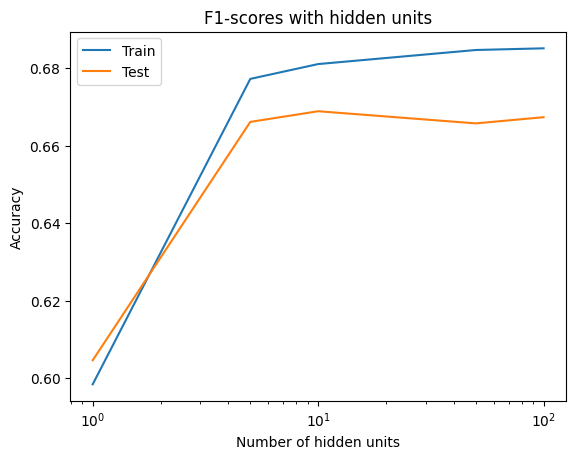

In [33]:
fig, ax = plt.subplots()

ax.plot(hidden_size_list, train_f1_score_list_uni, label="Train")
ax.plot(hidden_size_list, test_f1_score_list_uni, label="Test")

plt.legend()
plt.title('F1-scores with hidden units')
plt.xlabel('Number of hidden units')
plt.ylabel('Accuracy')
plt.xscale('log')

(c) Multilayer ANN

In [40]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_mul = []
test_f1_score_list_mul = []
for hidden_size in hidden_size_list:
    nn_mul = ANN(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_mul.train(X_train, y_train_oh, epochs=500, lr=0.1, tol=1e-8)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_mul = nn_mul.predict(X_train)
    get_metric(y_train, y_pred_mul)

    f1_score = get_f1score(y_train, y_pred_mul)
    train_f1_score_list_mul.append(f1_score)

    print("Test scores:-")
    y_pred_mul = nn_mul.predict(X_test)
    get_metric(y_test, y_pred_mul)

    f1_score = get_f1score(y_test, y_pred_mul)
    test_f1_score_list_mul.append(f1_score)

Epoch 0/500 - Loss: 1.8419
Epoch 10/500 - Loss: 0.9833
Epoch 20/500 - Loss: 0.8587
Epoch 30/500 - Loss: 0.8074
Epoch 40/500 - Loss: 0.7794
Epoch 50/500 - Loss: 0.7620
Epoch 60/500 - Loss: 0.7503
Epoch 70/500 - Loss: 0.7420
Epoch 80/500 - Loss: 0.7359
Epoch 90/500 - Loss: 0.7311
Epoch 100/500 - Loss: 0.7273
Epoch 110/500 - Loss: 0.7242
Epoch 120/500 - Loss: 0.7216
Epoch 130/500 - Loss: 0.7194
Epoch 140/500 - Loss: 0.7175
Epoch 150/500 - Loss: 0.7158
Epoch 160/500 - Loss: 0.7143
Epoch 170/500 - Loss: 0.7130
Epoch 180/500 - Loss: 0.7118
Epoch 190/500 - Loss: 0.7107
Epoch 200/500 - Loss: 0.7096
Epoch 210/500 - Loss: 0.7086
Epoch 220/500 - Loss: 0.7077
Epoch 230/500 - Loss: 0.7069
Epoch 240/500 - Loss: 0.7060
Epoch 250/500 - Loss: 0.7052
Epoch 260/500 - Loss: 0.7045
Epoch 270/500 - Loss: 0.7037
Epoch 280/500 - Loss: 0.7030
Epoch 290/500 - Loss: 0.7023
Epoch 300/500 - Loss: 0.7016
Epoch 310/500 - Loss: 0.7009
Epoch 320/500 - Loss: 0.7003
Epoch 330/500 - Loss: 0.6996
Epoch 340/500 - Loss: 0.6

Why does it look like the loss/epoch changes slower here (compared to cpu/numpy)?? 

Falls into convergence tolerance much easier.

In [41]:
train_f1_score_list_mul

[0.6764047055902279,
 0.6796120873036285,
 0.6713380959633458,
 0.6298711216801112]

In [42]:
test_f1_score_list_mul

[0.6675767963886907,
 0.6721147156040143,
 0.6705228644247626,
 0.6283091474576038]

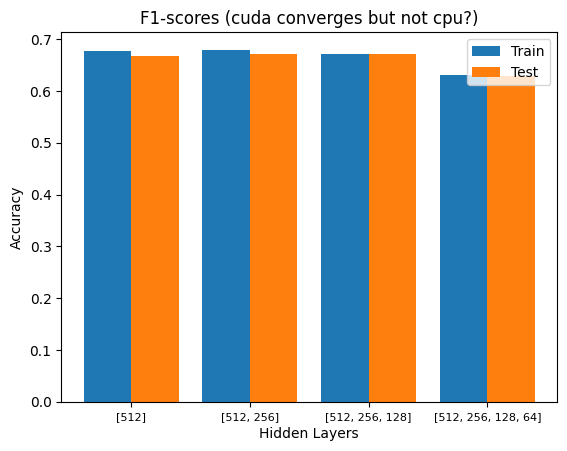

In [47]:
n4 = np.arange(4).get()
plt.bar(n4 - 0.2, train_f1_score_list_mul, 0.4, label="Train")
plt.bar(n4 + 0.2, test_f1_score_list_mul, 0.4, label="Test")

plt.xticks(n4, hidden_size_list)
plt.rc('xtick', labelsize=8)
plt.title('F1-scores (cuda converges but not cpu?)')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.legend()

(d) Adaptive Learning Rate

In [56]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_adpt = []
test_f1_score_list_adpt = []
for hidden_size in hidden_size_list:
    nn_adpt = ANN(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_adpt.train(X_train, y_train_oh, epochs=1000, tol=1e-12, lr=0.1, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_adpt = nn_adpt.predict(X_train)
    get_metric(y_train, y_pred_adpt)

    f1_score = get_f1score(y_train, y_pred_adpt)
    train_f1_score_list_adpt.append(f1_score)

    print("Test scores:-")
    y_pred_adpt = nn_adpt.predict(X_test)
    get_metric(y_test, y_pred_adpt)

    f1_score = get_f1score(y_test, y_pred_adpt)
    test_f1_score_list_adpt.append(f1_score)

Epoch 0/1000 - Loss: 2.1473
Epoch 10/1000 - Loss: 3.6084
Epoch 20/1000 - Loss: 1.7306
Epoch 30/1000 - Loss: 1.3151
Epoch 40/1000 - Loss: 1.2076
Epoch 50/1000 - Loss: 1.1795
Epoch 60/1000 - Loss: 1.1724
Epoch 70/1000 - Loss: 1.1721
Epoch 80/1000 - Loss: 1.1737
Epoch 90/1000 - Loss: 1.1753
Epoch 100/1000 - Loss: 1.1766
Epoch 110/1000 - Loss: 1.1777
Epoch 120/1000 - Loss: 1.1785
Epoch 130/1000 - Loss: 1.1792
Epoch 140/1000 - Loss: 1.1798
Epoch 150/1000 - Loss: 1.1804
Epoch 160/1000 - Loss: 1.1810
Epoch 170/1000 - Loss: 1.1817
Epoch 180/1000 - Loss: 1.1824
Epoch 190/1000 - Loss: 1.1834
Epoch 200/1000 - Loss: 1.1845
Epoch 210/1000 - Loss: 1.1858
Epoch 220/1000 - Loss: 1.1873
Epoch 230/1000 - Loss: 1.1889
Epoch 240/1000 - Loss: 1.1904
Epoch 250/1000 - Loss: 1.1920
Epoch 260/1000 - Loss: 1.1936
Epoch 270/1000 - Loss: 1.1952
Epoch 280/1000 - Loss: 1.1970
Epoch 290/1000 - Loss: 1.1989
Epoch 300/1000 - Loss: 1.2011
Epoch 310/1000 - Loss: 1.2036
Epoch 320/1000 - Loss: 1.2063
Epoch 330/1000 - Loss

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

Epoch 10/1000 - Loss: 1.6329
Epoch 20/1000 - Loss: 1.6430
Epoch 30/1000 - Loss: 1.6509
Epoch 40/1000 - Loss: 1.6496
Epoch 50/1000 - Loss: 1.6460
Epoch 60/1000 - Loss: 1.6421
Epoch 70/1000 - Loss: 1.6386
Epoch 80/1000 - Loss: 1.6353
Epoch 90/1000 - Loss: 1.6313
Epoch 100/1000 - Loss: 1.6135
Epoch 110/1000 - Loss: 1.4240
Epoch 120/1000 - Loss: 1.2220
Epoch 130/1000 - Loss: 1.1795
Epoch 140/1000 - Loss: 1.1702
Epoch 150/1000 - Loss: 1.1686
Epoch 160/1000 - Loss: 1.1690
Epoch 170/1000 - Loss: 1.1694
Epoch 180/1000 - Loss: 1.1693
Epoch 190/1000 - Loss: 1.1687
Epoch 200/1000 - Loss: 1.1673
Epoch 210/1000 - Loss: 1.1607
Epoch 220/1000 - Loss: 1.1443
Epoch 230/1000 - Loss: 1.1269
Epoch 240/1000 - Loss: 1.1077
Epoch 250/1000 - Loss: 1.0916
Epoch 260/1000 - Loss: 1.0781
Epoch 270/1000 - Loss: 1.0673
Epoch 280/1000 - Loss: 1.0586
Epoch 290/1000 - Loss: 1.0499
Epoch 300/1000 - Loss: 1.0370
Epoch 310/1000 - Loss: 0.9999
Epoch 320/1000 - Loss: 0.9417
Epoch 330/1000 - Loss: 0.9099
Epoch 340/1000 - Lo

In [57]:
test_f1_score_list_adpt

[0.26448244625104556,
 0.6519682343970741,
 0.6649592255867677,
 0.5928465009876108]

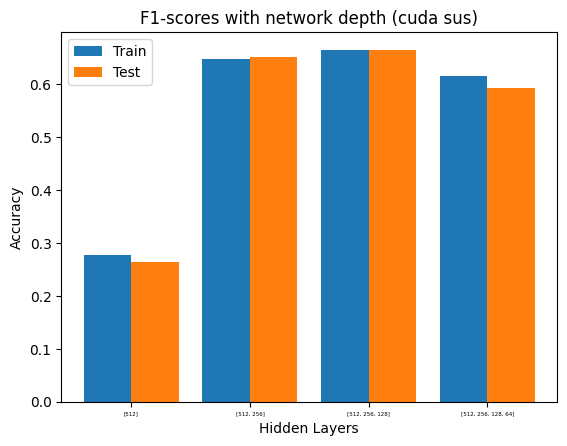

In [60]:
n4 = np.arange(4).get()
plt.bar(n4 - 0.2, train_f1_score_list_adpt, 0.4, label="Train")
plt.bar(n4 + 0.2, test_f1_score_list_adpt, 0.4, label="Test")

plt.xticks(n4, hidden_size_list)
plt.rc('xtick', labelsize=4)
plt.title('F1-scores with network depth (cuda sus)')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.legend()

In [67]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_adpt = []
test_f1_score_list_adpt = []
for hidden_size in hidden_size_list:
    nn_adpt = ANN(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_adpt.train(X_train, y_train_oh, epochs=1000, tol=1e-6, lr=0.5, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_adpt = nn_adpt.predict(X_train)
    get_metric(y_train, y_pred_adpt)

    f1_score = get_f1score(y_train, y_pred_adpt)
    train_f1_score_list_adpt.append(f1_score)

    print("Test scores:-")
    y_pred_adpt = nn_adpt.predict(X_test)
    get_metric(y_test, y_pred_adpt)

    f1_score = get_f1score(y_test, y_pred_adpt)
    test_f1_score_list_adpt.append(f1_score)

Epoch 0/1000 - Loss: 1.9116
Epoch 10/1000 - Loss: 0.7562
Epoch 20/1000 - Loss: 0.7148
Epoch 30/1000 - Loss: 0.6877
Epoch 40/1000 - Loss: 0.6657
Epoch 50/1000 - Loss: 0.6455
Epoch 60/1000 - Loss: 0.6267
Epoch 70/1000 - Loss: 0.6095
Epoch 80/1000 - Loss: 0.5945
Epoch 90/1000 - Loss: 0.5817
Epoch 100/1000 - Loss: 0.5707
Epoch 110/1000 - Loss: 0.5610
Epoch 120/1000 - Loss: 0.5520
Epoch 130/1000 - Loss: 0.5436
Epoch 140/1000 - Loss: 0.5356
Epoch 150/1000 - Loss: 0.5280
Epoch 160/1000 - Loss: 0.5207
Epoch 170/1000 - Loss: 0.5137
Epoch 180/1000 - Loss: 0.5070
Epoch 190/1000 - Loss: 0.5005
Epoch 200/1000 - Loss: 0.4942
Epoch 210/1000 - Loss: 0.4882
Epoch 220/1000 - Loss: 0.4825
Epoch 230/1000 - Loss: 0.4770
Epoch 240/1000 - Loss: 0.4717
Epoch 250/1000 - Loss: 0.4666
Epoch 260/1000 - Loss: 0.4617
Epoch 270/1000 - Loss: 0.4570
Epoch 280/1000 - Loss: 0.4524
Epoch 290/1000 - Loss: 0.4481
Epoch 300/1000 - Loss: 0.4438
Epoch 310/1000 - Loss: 0.4398
Epoch 320/1000 - Loss: 0.4358
Epoch 330/1000 - Loss

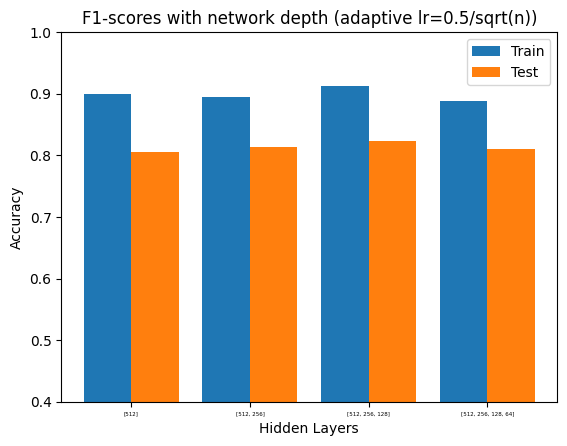

In [70]:
plt.bar(np.arange(4) - 0.2, train_f1_score_list_adpt, 0.4, label="Train")
plt.bar(np.arange(4) + 0.2, test_f1_score_list_adpt, 0.4, label="Test")

plt.xticks(np.arange(4), hidden_size_list)
plt.rc('xtick', labelsize=8)
plt.title('F1-scores with network depth (adaptive lr=0.5/sqrt(n))')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
plt.legend()

The learning rate used seems to work much better than with seed=0.01. All the models gain much better scores than before. We can see an increasing trend with network depth, as the f1 scores go from below 80 to 90+. But it falls off at [512,256,128,64], most likely because the learning rate we chose for this model was too large(can be inferred from the losses increasing near the epoch ends), that can be controlled by stopping our model when loss function increases. (Infact, the 3rd model also showed min loss = 0.1964)
Nevertheless, running for more than 500 epochs was useful since test results improve, suggesting an underfit earlier. The adaptive lr also helps deal with overfitting here.

(e) RelU Activation

In [12]:
def relu(x, clip=100, downscale=1):
    return np.where(x>0, np.where(x>clip, clip, x)*downscale, 0)

def relu_grad(x, clip=100, downscale=1):
    # subderivative at x=0 is set to 1(right limit)
    # subderivative at x=clip is set to 0(right limit)
    return np.where(x>=0, np.where(x>=clip, 0, downscale), 0)

In [39]:
class ANN_Relu(ANN):
    def fwd_prop(self, X):
        # list of layer outputs
        self.z = []
        self.actv = []

        A = X
        
        self.actv.append(A)
        self.z.append(np.eye(A.shape[0], A.shape[1]))        # to maintain same length

        for i in range(self.num_layers):
            Z = A@self.weights[i] + self.biases[i]
            self.z.append(Z)

            if i == self.num_layers-1:
                A = softmax(Z)
            else:
                A = relu(Z, clip=6.875)

            self.actv.append(A)

        # len(self.actv) == self.num_layers + 1 == len(self.weights) + 1
        return A
    
    def bwd_prop(self, y_true, lr):
        m = y_true.shape[0]
        y_pred = self.actv[-1]

        self.w_grad = []
        self.b_grad = []

        dZ = cross_entropy_grad_netk(y_true, y_pred)
        # dActv = softmax_grad(self.z[-1]).mean(axis=0)

        # print(dActv.shape)
        # print(dZ.shape)

        dB = np.mean(dZ, axis=0, keepdims=True)
        self.biases[-1] -= lr*dB
        self.b_grad.append(dB)

        dW = self.actv[-2].T@dZ/m


        # print(dW[0])
        # print(dW.shape)

        self.weights[-1] -= lr*dW
        self.w_grad.append(dW)

        for l in range(self.num_layers-2,-1,-1):
            dJd = dZ@self.weights[l+1].T
            dActv = relu_grad(self.z[l+1], clip=6.875).mean(axis=0)
    
            dZ = dJd*dActv
            dW = self.actv[l].T@dZ/m
            self.w_grad.append(dW)
            
            dB = np.mean(dZ, axis=0, keepdims=True)
            self.b_grad.append(dB)

            self.weights[l] -= lr*dW
            self.biases[l] -= lr*dB

        self.w_grad.reverse()
        self.b_grad.reverse()

        return self.w_grad, self.b_grad

In [14]:
import time

clip = 6.8 : within tol ; = 6.9 : overflow lol

In [40]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_relu = []
test_f1_score_list_relu = []
for hidden_size in hidden_size_list:
    t = time.time()
    nn_relu = ANN_Relu(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_relu.train(X_train, y_train_oh, epochs=500, tol=1e-6, lr=0.1, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_relu = nn_relu.predict(X_train)
    get_metric(y_train, y_pred_relu)

    f1_score = get_f1score(y_train, y_pred_relu)
    train_f1_score_list_relu.append(f1_score)

    print("Test scores:-")
    y_pred_relu = nn_relu.predict(X_test)
    get_metric(y_test, y_pred_relu)

    f1_score = get_f1score(y_test, y_pred_relu)
    test_f1_score_list_relu.append(f1_score)

    print(f"Time taken for {hidden_size}= {time.time()-t}")

Epoch 0/500 - Loss: 1.7712
Within tolerance = 1e-06
For hidden_size: [512]:
Train scores:-


c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       1.00      0.20      0.33     10000
         5.0       0.00      0.00      0.00         0

    accuracy                           0.20     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.20      0.33     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       1.00      0.19      0.32      1000
         5.0       0.00      0.00      0.00         0

    accuracy                           0.19      1000
   macro avg       0.20      0.04      0.06      1000
weighted avg       1.00      0.19      0.32      1000

Time tak

KeyboardInterrupt: 

In [104]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_relu = []
test_f1_score_list_relu = []
for hidden_size in hidden_size_list:
    t = time.time()
    nn_relu = ANN_Relu(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_relu.train(X_train, y_train_oh, epochs=500, tol=1e-6, lr=0.01, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_relu = nn_relu.predict(X_train)
    get_metric(y_train, y_pred_relu)

    f1_score = get_f1score(y_train, y_pred_relu)
    train_f1_score_list_relu.append(f1_score)

    print("Test scores:-")
    y_pred_relu = nn_relu.predict(X_test)
    get_metric(y_test, y_pred_relu)

    f1_score = get_f1score(y_test, y_pred_relu)
    test_f1_score_list_relu.append(f1_score)

    print(f"Time taken for {hidden_size}= {time.time()-t}")

Epoch 0/500 - Loss: 1.8558
Epoch 10/500 - Loss: 0.8375
Epoch 20/500 - Loss: 0.7892
Epoch 30/500 - Loss: 0.7675
Epoch 40/500 - Loss: 0.7544
Epoch 50/500 - Loss: 0.7455
Epoch 60/500 - Loss: 0.7390
Epoch 70/500 - Loss: 0.7340
Epoch 80/500 - Loss: 0.7300
Epoch 90/500 - Loss: 0.7266
Epoch 100/500 - Loss: 0.7238
Epoch 110/500 - Loss: 0.7214
Epoch 120/500 - Loss: 0.7192
Epoch 130/500 - Loss: 0.7173
Epoch 140/500 - Loss: 0.7156
Epoch 150/500 - Loss: 0.7141
Epoch 160/500 - Loss: 0.7127
Epoch 170/500 - Loss: 0.7114
Epoch 180/500 - Loss: 0.7102
Epoch 190/500 - Loss: 0.7090
Epoch 200/500 - Loss: 0.7080
Epoch 210/500 - Loss: 0.7070
Epoch 220/500 - Loss: 0.7061
Epoch 230/500 - Loss: 0.7052
Epoch 240/500 - Loss: 0.7044
Epoch 250/500 - Loss: 0.7036
Epoch 260/500 - Loss: 0.7029
Epoch 270/500 - Loss: 0.7022
Epoch 280/500 - Loss: 0.7015
Epoch 290/500 - Loss: 0.7008
Epoch 300/500 - Loss: 0.7002
Epoch 310/500 - Loss: 0.6996
Epoch 320/500 - Loss: 0.6990
Epoch 330/500 - Loss: 0.6984
Epoch 340/500 - Loss: 0.6

Reduced the learning rate back to 0.01 because it was exploding the weights(presumably because ReLU isn't bound like sigmoid). Also, reduced the epoch limit back to 500 since ReLU should ideally take lesser time to converge. 

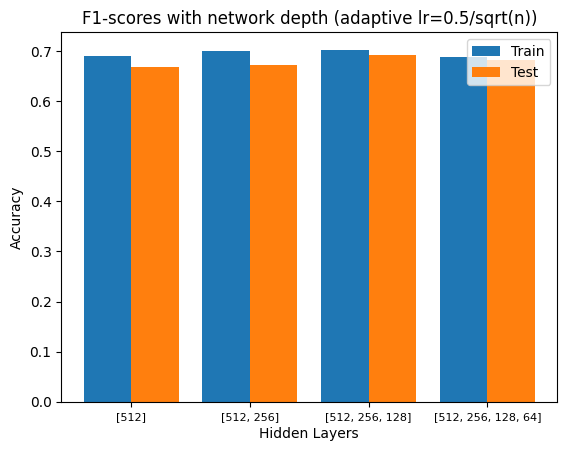

In [107]:
plt.bar(np.arange(4) - 0.2, train_f1_score_list_relu, 0.4, label="Train")
plt.bar(np.arange(4) + 0.2, test_f1_score_list_relu, 0.4, label="Test")

plt.xticks(np.arange(4), hidden_size_list)
plt.rc('xtick', labelsize=8)
plt.title('F1-scores with network depth (adaptive lr=0.5/sqrt(n))')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# fig, ax = plt.subplots()

# ax.plot(hidden_size_list, train_f1_score_list_relu, label="Train")
# ax.plot(hidden_size_list, test_f1_score_list_relu, label="Test")

# plt.title('F1-scores with network depth (adaptive lr=0.5/sqrt(n))')
# plt.xlabel('Network depth')
# plt.ylabel('F1-score')

We see f1-scores around the 70% mark, improving faintly with network depth. The last model converges before 500 epochs as the error falls into the tolerance limit, making it run for almost half the time of the previous one, while giving almost the same results.

Compared to the sigmoid-based models, the relu-based models do infact seem to perform better If we compare results with same learning seed = 0.01, there is an increase of around 4% over their sigmoid counterparts. It would be interesting to see the performance of relu model with higher lr(need to figure out a solution to blowing-up gradients, probably tweaking units to have falling weights https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network)

In [116]:
asa = np.random.randn(2,5)
wasa = asa - asa.max(axis=1, keepdims=True)
print(asa)
print(wasa)

[[-0.53101805 -1.02723312  0.16240695 -0.39949213 -1.44761306]
 [ 0.20130473  0.2859648   1.12963881  0.46036328  2.20221144]]
[[-0.693425   -1.18964007  0.         -0.56189909 -1.61002001]
 [-2.00090671 -1.91624664 -1.07257263 -1.74184816  0.        ]]


In [119]:
print(softmax(asa))
print(softmax(wasa))

[[0.19418108 0.1182234  0.38847008 0.22147663 0.0776488 ]
 [0.07513088 0.08176847 0.19010295 0.09734781 0.55564989]]
[[0.19418108 0.1182234  0.38847008 0.22147663 0.0776488 ]
 [0.07513088 0.08176847 0.19010295 0.09734781 0.55564989]]


One solution here seems to subtract the max value so that softmax layer doesn't overflow. (Edit: Other layers do, still might be a potential solution)

In [135]:
class ANN_Relu_Scale(ANN_Relu):
    def fwd_prop(self, X):
        # list of layer outputs
        self.z = []
        self.actv = []

        A = X
        
        self.actv.append(A)
        self.z.append(np.eye(A.shape[0], A.shape[1]))        # to maintain same length

        for i in range(self.num_layers):
            Z = A@self.weights[i] + self.biases[i]
            self.z.append(Z)

            if i == self.num_layers-1:
                # Z_modifive = Z - Z.max(axis=1, keepdims=True)
                A = softmax(Z)
                # A = softmax(Z_modifive)
            else:
                # also in previous layers?
                # Z_modifive = Z - Z.max(axis=1, keepdims=True)
                A = relu(Z, downscale=1e-2)

            self.actv.append(A)

        # len(self.actv) == self.num_layers + 1 == len(self.weights) + 1
        return A
    
    def bwd_prop(self, y_true, lr):
        m = y_true.shape[0]
        y_pred = self.actv[-1]

        self.w_grad = []
        self.b_grad = []

        dZ = cross_entropy_grad_netk(y_true, y_pred)
        # dActv = softmax_grad(self.z[-1]).mean(axis=0)

        # print(dActv.shape)
        # print(dZ.shape)

        dB = np.mean(dZ, axis=0, keepdims=True)
        self.biases[-1] -= lr*dB
        self.b_grad.append(dB)

        dW = self.actv[-2].T@dZ/m


        # print(dW[0])
        # print(dW.shape)

        self.weights[-1] -= lr*dW
        self.w_grad.append(dW)

        for l in range(self.num_layers-2,-1,-1):
            dJd = dZ@self.weights[l+1].T
            dActv = relu_grad(self.z[l+1], downscale=1e-2).mean(axis=0)
    
            dZ = dJd*dActv
            dW = self.actv[l].T@dZ/m
            self.w_grad.append(dW)
            
            dB = np.mean(dZ, axis=0, keepdims=True)
            self.b_grad.append(dB)

            self.weights[l] -= lr*dW
            self.biases[l] -= lr*dB

        self.w_grad.reverse()
        self.b_grad.reverse()

        return self.w_grad, self.b_grad

Current relu uses a downscale factor of 0.01 (tried others, 0.1 blows up and 0.001 vanishes).

In [136]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_relu_s = []
test_f1_score_list_relu_s = []
for hidden_size in hidden_size_list:
    t = time.time()
    nn_relu = ANN_Relu_Scale(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_relu.train(X_train, y_train_oh, epochs=500, tol=1e-6, lr=0.5, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_relu = nn_relu.predict(X_train)
    get_metric(y_train, y_pred_relu)

    f1_score = get_f1score(y_train, y_pred_relu)
    train_f1_score_list_relu_s.append(f1_score)

    print("Test scores:-")
    y_pred_relu = nn_relu.predict(X_test)
    get_metric(y_test, y_pred_relu)

    f1_score = get_f1score(y_test, y_pred_relu)
    test_f1_score_list_relu_s.append(f1_score)

    print(f"Time taken for {hidden_size}= {time.time()-t}")

Epoch 0/500 - Loss: 1.6093
Epoch 10/500 - Loss: 1.1942
Epoch 20/500 - Loss: 1.0015
Epoch 30/500 - Loss: 0.9306
Epoch 40/500 - Loss: 0.8907
Epoch 50/500 - Loss: 0.8644
Epoch 60/500 - Loss: 0.8456
Epoch 70/500 - Loss: 0.8312
Epoch 80/500 - Loss: 0.8199
Epoch 90/500 - Loss: 0.8107
Epoch 100/500 - Loss: 0.8031
Epoch 110/500 - Loss: 0.7967
Epoch 120/500 - Loss: 0.7912
Epoch 130/500 - Loss: 0.7864
Epoch 140/500 - Loss: 0.7822
Epoch 150/500 - Loss: 0.7784
Epoch 160/500 - Loss: 0.7751
Epoch 170/500 - Loss: 0.7721
Epoch 180/500 - Loss: 0.7693
Epoch 190/500 - Loss: 0.7668
Epoch 200/500 - Loss: 0.7645
Epoch 210/500 - Loss: 0.7624
Epoch 220/500 - Loss: 0.7604
Epoch 230/500 - Loss: 0.7586
Epoch 240/500 - Loss: 0.7569
Epoch 250/500 - Loss: 0.7553
Epoch 260/500 - Loss: 0.7538
Epoch 270/500 - Loss: 0.7524
Epoch 280/500 - Loss: 0.7511
Epoch 290/500 - Loss: 0.7498
Epoch 300/500 - Loss: 0.7486
Epoch 310/500 - Loss: 0.7475
Epoch 320/500 - Loss: 0.7464
Epoch 330/500 - Loss: 0.7454
Epoch 340/500 - Loss: 0.7

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.21      0.35     10000

    accuracy                           0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.19      0.32      1000

    accuracy                           0.19      1000
   macro avg       0.20      0.04      0.06      1000
weighted avg       1.00      0.19      0.32      1000

Time tak

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.21      0.35     10000

    accuracy                           0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.19      0.32      1000

    accuracy                           0.19      1000
   macro avg       0.20      0.04      0.06      1000
weighted avg       1.00      0.19      0.32      1000

Time tak

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

In [137]:
print(train_f1_score_list_relu_s)
print(test_f1_score_list_relu_s)

[0.6682746612988908, 0.06917541973368621, 0.06917541973368621, 0.06917541973368621]
[0.6633024260773688, 0.06301600673967986, 0.06301600673967986, 0.06301600673967986]


Only the single layered model runs properly on this downscaled relu function.

(f) MLP Classifier

In [108]:
from sklearn.neural_network import MLPClassifier

In [109]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list = []
test_f1_score_list = []

for hidden_size in hidden_size_list:
    mlp_clf = MLPClassifier(hidden_layer_sizes=hidden_size, activation='relu', solver='sgd', batch_size=32, alpha=0, learning_rate='invscaling')

    mlp_clf.fit(X_train, y_train)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_mlp = mlp_clf.predict(X_train)
    get_metric(y_train, y_pred_mlp)

    f1_score = get_f1score(y_train, y_pred_mlp)
    train_f1_score_list.append(f1_score)

    print("Test scores:-")
    y_pred_mlp = mlp_clf.predict(X_test)
    get_metric(y_test, y_pred_mlp)

    f1_score = get_f1score(y_test, y_pred_mlp)
    test_f1_score_list.append(f1_score)

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.91      0.71      0.79      2523
         2.0       0.45      0.52      0.48      1703
         3.0       0.34      0.46      0.39      1448
         4.0       0.34      0.45      0.39      1503
         5.0       0.82      0.61      0.70      2823

    accuracy                           0.57     10000
   macro avg       0.57      0.55      0.55     10000
weighted avg       0.64      0.57      0.59     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.89      0.73      0.80       277
         2.0       0.40      0.49      0.44       162
         3.0       0.32      0.45      0.37       141
         4.0       0.34      0.40      0.37       161
         5.0       0.78      0.56      0.65       259

    accuracy                           0.56      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.61 

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512, 256]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.90      0.78      0.83      2267
         2.0       0.54      0.58      0.56      1823
         3.0       0.43      0.47      0.45      1791
         4.0       0.37      0.45      0.40      1638
         5.0       0.75      0.63      0.68      2481

    accuracy                           0.60     10000
   macro avg       0.60      0.58      0.59     10000
weighted avg       0.62      0.60      0.61     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.87      0.80      0.84       250
         2.0       0.51      0.56      0.53       179
         3.0       0.40      0.48      0.44       167
         4.0       0.37      0.40      0.39       171
         5.0       0.68      0.55      0.60       233

    accuracy                           0.58      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512, 256, 128]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.89      0.82      0.86      2143
         2.0       0.62      0.62      0.62      1981
         3.0       0.46      0.49      0.47      1816
         4.0       0.37      0.45      0.41      1653
         5.0       0.74      0.64      0.69      2407

    accuracy                           0.62     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.64      0.62      0.63     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.88      0.84      0.86       240
         2.0       0.57      0.59      0.58       193
         3.0       0.47      0.51      0.49       183
         4.0       0.40      0.44      0.42       168
         5.0       0.71      0.61      0.66       216

    accuracy                           0.61      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg  

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512, 256, 128, 64]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.89      0.84      0.87      2098
         2.0       0.63      0.65      0.64      1909
         3.0       0.49      0.51      0.50      1871
         4.0       0.41      0.47      0.44      1773
         5.0       0.75      0.66      0.70      2349

    accuracy                           0.64     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.65      0.64      0.64     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.90      0.87      0.88       238
         2.0       0.59      0.63      0.61       183
         3.0       0.50      0.54      0.52       183
         4.0       0.46      0.44      0.45       194
         5.0       0.70      0.64      0.67       202

    accuracy                           0.64      1000
   macro avg       0.63      0.63      0.63      1000
weighted a

Text(0, 0.5, 'Accuracy')

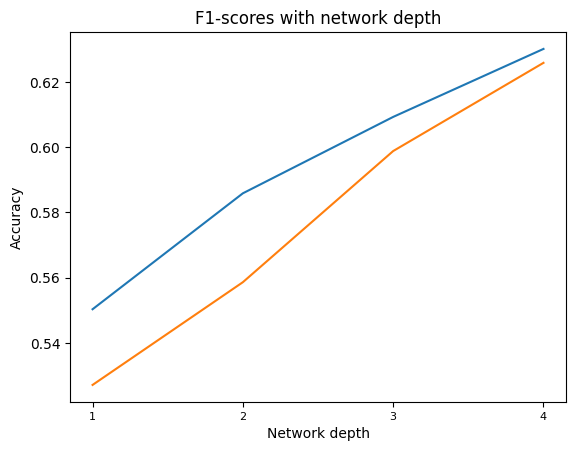

In [142]:
fig, ax = plt.subplots()

ax.plot(np.arange(1,5), train_f1_score_list, label="Train")
ax.plot(np.arange(1,5), test_f1_score_list, label="Test")

plt.title('F1-scores with network depth')
plt.xlabel('Network depth')
plt.xticks(np.arange(1,5))
plt.ylabel('Accuracy')